In [4]:
import numpy as np 
import pandas as pd 
from scipy.stats import percentileofscore
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import optuna
import warnings
warnings.filterwarnings("ignore")
df_train = pd.read_csv("/kaggle/input/playground-series-s4e10/train.csv",index_col = 'id')
df_test = pd.read_csv("/kaggle/input/playground-series-s4e10/test.csv", index_col="id")
df_submit = pd.read_csv("/kaggle/input/playground-series-s4e10/sample_submission.csv")

In [5]:
# Функция доли выбросов в числовых столбцах DataFrame
def outliers_report(df):
    '''
    Returns:
               outliers_df: DataFrame с границами выбросов и долей выбросов
               outlier_metrics: Список мер удаленности выбросов (процентилей)
               outlier_indices: Список индексов строк с выбросами
    '''
    numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns
    lower_norms = {}
    upper_norms = {}
    out_parts = {}
    outlier_indices = []
    outlier_metrics = []

    for col in numeric_cols:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        median = df[col].quantile(0.5)

        lower_norm = median - 1.5 * iqr
        upper_norm = median + 1.5 * iqr

        lower_norms[col] = lower_norm  # заполнить пустой словарь
        upper_norms[col] = upper_norm

        # Считаем долю выбросов 
        outliers = df[(df[col] < lower_norm) | (df[col] > upper_norm)][col]
        out_parts[col] = len(outliers) / len(df[col])

        # Собираем индексы и метрики
        for index, value in outliers.items():  #Итерируемся по выбросам
            outlier_indices.append(index)
            percentile = percentileofscore(df[col], value)
            outlier_metrics.append(min(percentile, 100 - percentile)) 

    # Создаем DataFrame с результатами
    outliers_data = {'lower_norm': lower_norms, 'upper_norm': upper_norms, 'out_part': out_parts}
    outliers_df = pd.DataFrame(outliers_data).transpose()  # Транспонируем для правильной структуры

    # Сортируем метрики и индексы
    sorted_metrics, sorted_indices = zip(*sorted(zip(outlier_metrics, outlier_indices))) if outlier_metrics else ([], []) # Обрабатываем случай пустых списков

    return outliers_df, sorted_metrics, sorted_indices


# Функция определения доли пропущенных значений по столбцам
def miss_data(df):

    x = ['column_name','missing_data', 'missing_in_percentage']
    missing_data = pd.DataFrame(columns=x)
    columns = df.columns
    
    for col in columns:
        icolumn_name = col
        imissing_data = df[col].isnull().sum()
        imissing_in_percentage = (df[col].isnull().sum()/df[col].shape[0])*100
        
        missing_data.loc[len(missing_data)] = [icolumn_name, imissing_data, imissing_in_percentage]
    print(missing_data) 


# Вывести информацию об уникальных значениях по каждому столбцу. Способ 2
def value_info(df):
    
    value_info_1 = pd.Series({c: df[c].unique() for c in df}).to_frame().reset_index()
    nuniques = []
    
    for col in df.columns:
        nuniques.append(df[col].nunique())
        
    value_info_1['nuniques'] = nuniques
    return value_info_1

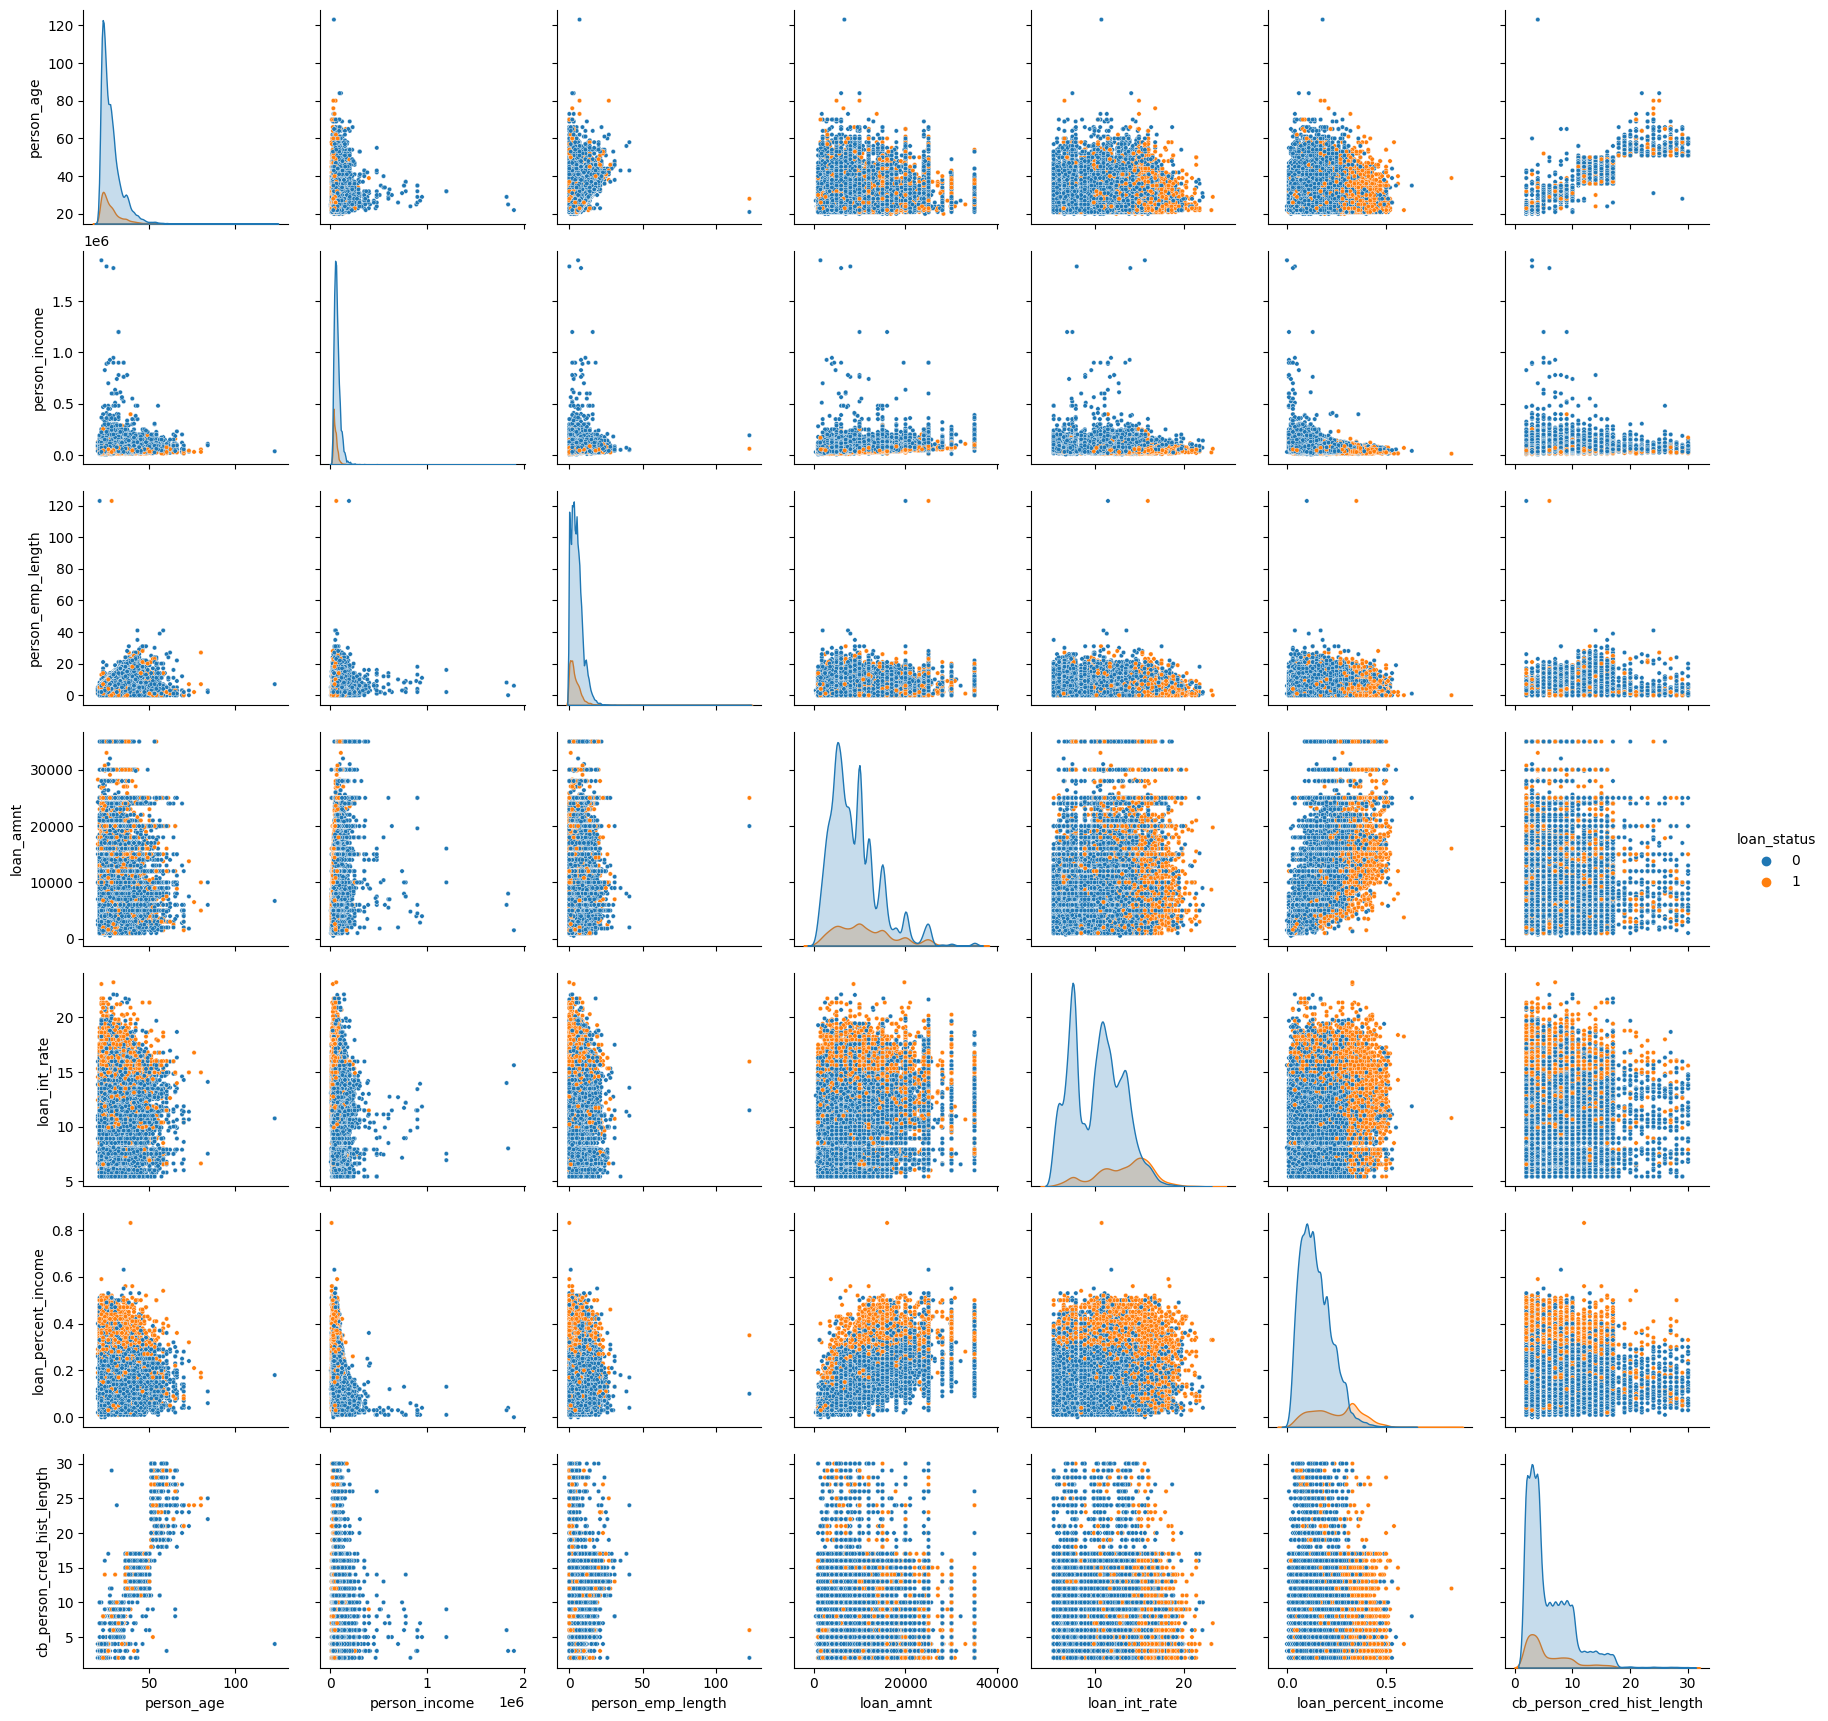

In [6]:
sns.pairplot(df_train, hue = 'loan_status', plot_kws={"s": 10})

In [7]:
df_train = df_train.drop([47336,41079,49252])

In [8]:
# Five models: XGB, XGB1, RF, RF1, CB1

In [9]:
X_train, y_train = df_train.drop(['loan_status'],axis=1), df_train['loan_status'].values
X_test = df_test
X_train.shape, y_train.shape, X_test.shape

((58642, 11), (58642,), (39098, 11))

In [10]:
X_train1 = X_train
X_train1["person_age_person_income"] = ((X_train1["person_age"] / X_train1["person_income"]))
X_train1["person_age_person_emp_length"] = ((X_train1["person_age"] / X_train1["person_emp_length"]))
X_train1["person_age_person_loan_amnt"] = ((X_train1["person_age"] / X_train1["loan_amnt"]))
X_train1["person_age_person_loan_int_rate"] = ((X_train1["person_age"] / X_train1["loan_int_rate"]))
X_train1["person_age_person_loan_percent_income"] = ((X_train1["person_age"] / X_train1["loan_percent_income"]))
X_train1["person_income_person_emp_length"] = ((X_train1["person_income"] / X_train1["person_emp_length"]))
X_train1["person_income_person_loan_amnt"] = ((X_train1["person_income"] / X_train1["loan_amnt"]))
X_train1["person_income_person_loan_int_rate"] = ((X_train1["person_income"] / X_train1["loan_int_rate"]))
X_train1["person_emp_length_loan_amnt"] = ((X_train1["person_emp_length"] / X_train1["loan_amnt"]))
X_train1["person_emp_length_loan_int_rate"] = ((X_train1["person_emp_length"] / X_train1["loan_int_rate"]))
X_train1["person_emp_length_loan_percent_income"] = ((X_train1["person_emp_length"] / X_train1["loan_percent_income"]))
X_train1["loan_amnt_loan_int_rate"] = ((X_train1["loan_amnt"] / X_train1["loan_int_rate"]))
X_train1["loan_int_rate_loan_percent_income"] = ((X_train1["loan_int_rate"] / X_train1["loan_percent_income"]))
X_train1 = X_train1.replace([np.inf, -np.inf], 0)
X_train1.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,...,person_age_person_loan_int_rate,person_age_person_loan_percent_income,person_income_person_emp_length,person_income_person_loan_amnt,person_income_person_loan_int_rate,person_emp_length_loan_amnt,person_emp_length_loan_int_rate,person_emp_length_loan_percent_income,loan_amnt_loan_int_rate,loan_int_rate_loan_percent_income
id,,,,,,,,,,,,,,,,,,,,,
0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,...,3.220191,217.647059,0.000000,5.833333,3046.127067,0.000000,0.000000,0.000000,522.193211,67.588235
1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,...,1.647940,314.285714,9333.333333,14.000000,4194.756554,0.001500,0.449438,85.714286,299.625468,190.714286
2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,...,3.258427,138.095238,3600.000000,4.800000,3235.955056,0.001333,0.898876,38.095238,674.157303,42.380952
3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,...,2.700270,176.470588,5000.000000,5.833333,6300.630063,0.001167,1.260126,82.352941,1080.108011,65.352941
4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,...,3.179191,220.000000,30000.000000,10.000000,8670.520231,0.000333,0.289017,20.000000,867.052023,69.200000


In [12]:
X_train1.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,person_age_person_income,person_age_person_emp_length,person_age_person_loan_amnt,person_age_person_loan_int_rate,person_age_person_loan_percent_income,person_income_person_emp_length,person_income_person_loan_amnt,person_income_person_loan_int_rate,person_emp_length_loan_amnt,person_emp_length_loan_int_rate,person_emp_length_loan_percent_income,loan_amnt_loan_int_rate,loan_int_rate_loan_percent_income
count,58642.000000,5.864200e+04,58642.000000,58642.000000,58642.000000,58642.000000,58642.000000,58642.000000,58642.000000,58642.000000,58642.000000,58642.000000,58642.000000,58642.000000,58642.000000,58642.000000,58642.000000,58642.000000,58642.000000,58642.000000
mean,27.549333,6.404453e+04,4.696941,9217.146448,10.677770,0.159235,5.813649,0.000527,7.548805,0.004504,2.814787,262.033122,16916.701342,9.467341,6611.159386,0.000734,0.494269,46.276040,922.025625,98.731694
std,6.020420,3.792822e+04,3.899139,5563.380070,3.034695,0.091690,4.029261,0.000272,7.798573,0.003922,1.075953,248.461656,20537.881039,10.191503,4590.445237,0.000978,0.472403,69.434126,589.813783,92.649261
min,20.000000,4.200000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,0.000012,0.000000,0.000600,0.954033,0.000000,0.000000,0.320000,382.848392,0.000000,0.000000,0.000000,38.940810,0.000000
25%,23.000000,4.200000e+04,2.000000,5000.000000,7.880000,0.090000,3.000000,0.000344,2.800000,0.002200,2.002861,125.000000,6145.333333,4.777778,3782.505910,0.000200,0.155400,10.526316,483.091787,48.088235
50%,26.000000,5.800000e+04,4.000000,8000.000000,10.750000,0.140000,4.000000,0.000467,4.800000,0.003333,2.561118,191.666667,11000.000000,7.029911,5566.801619,0.000480,0.380711,26.666667,794.952361,72.555556
75%,30.000000,7.560000e+04,7.000000,12000.000000,12.990000,0.210000,8.000000,0.000643,9.666667,0.005333,3.375121,311.111111,20000.000000,11.200000,8230.452675,0.000933,0.685871,55.555556,1234.567901,115.363636
max,84.000000,1.900000e+06,41.000000,35000.000000,23.220000,0.830000,30.000000,0.005952,70.000000,0.054000,12.084592,5500.000000,600000.000000,1266.666667,229973.000000,0.020500,6.457565,2000.000000,5843.071786,1969.000000


In [13]:
def find_duplicates(with_duplicates,without_duplicates):
    duplicates = []
    for i, item in enumerate(with_duplicates):
        if item in without_duplicates:
            without_duplicates.remove(item)
        else:
            duplicates.append(item)
    return(set(duplicates))
#print(len(index))
#print(len(delete_all_outliers))
#find_duplicates(indexx,delete_all_outliers)

In [14]:
df_report,metrics,indexx = outliers_report(X_train1)

In [15]:
len(indexx)

104892

In [16]:
indexx_without_duplicates = list(dict.fromkeys(indexx))   # len = 12200
len(indexx_without_duplicates)

34958

In [18]:
#indexx_without_duplicates[0:500]

In [ ]:
X_train1 = X_train1.replace([np.inf, -np.inf], 0)
for_one_hot_encoding = X_train1.loc[:,['person_home_ownership','loan_intent']]
X_train1 = pd.concat([X_train1, pd.get_dummies(for_one_hot_encoding)],axis=1)
X_train1 = X_train1.drop(['person_home_ownership','loan_intent'],axis = 1)
for_ordinal_encoder = list(X_train1.select_dtypes(include=["object"]).columns)
oe = OrdinalEncoder()
X_train1[for_ordinal_encoder] = oe.fit_transform(X_train1[for_ordinal_encoder])
roc_auc = []
check = []
y_train = pd.DataFrame(y_train)
for i in range(500,6001,500):
    cut = indexx_without_duplicates[i-500:i]
    X_train1 = X_train1.drop(index = cut,axis=0)
    y_train = y_train.drop(index = cut,axis=0)
    clf_rf_1 = RandomForestClassifier(n_estimators = 190, max_depth = 15, 
                  min_samples_split = 6, min_samples_leaf = 2)
    clf_rf_1.fit(X_train1,y_train)
    roc_auc.append(cross_val_score(clf_rf_1,X_train1,y_train,scoring = 'roc_auc',cv = 6).mean())
    check.append(len(X_train1.index))

In [ ]:
check

In [ ]:
roc_auc

In [ ]:
cut = indexx_without_duplicates[0:6000]
X_train1 = X_train1.drop(index = cut,axis=0)
y_train = pd.DataFrame(y_train)
y_train = y_train.drop(index = cut,axis=0)
X_train1 = X_train1.replace([np.inf, -np.inf], 0)

for_one_hot_encoding = X_train1.loc[:,['person_home_ownership','loan_intent']]
X_train1 = pd.concat([X_train1, pd.get_dummies(for_one_hot_encoding)],axis=1)
X_train1 = X_train1.drop(['person_home_ownership','loan_intent'],axis = 1)

for_ordinal_encoder = list(X_train1.select_dtypes(include=["object"]).columns)
oe = OrdinalEncoder()
X_train1[for_ordinal_encoder] = oe.fit_transform(X_train1[for_ordinal_encoder])

roc_auc2 = []
check = []
y_train = pd.DataFrame(y_train)

for i in range(6001,12002,500):
    
    cut = indexx_without_duplicates[i-500:i]
    X_train1 = X_train1.drop(index = cut,axis=0)
    y_train = y_train.drop(index = cut,axis=0)
    clf_rf_1 = RandomForestClassifier(n_estimators = 190, max_depth = 15, 
                  min_samples_split = 6, min_samples_leaf = 2)
    clf_rf_1.fit(X_train1,y_train)
    roc_auc2.append(cross_val_score(clf_rf_1,X_train1,y_train,scoring = 'roc_auc',cv = 6).mean())
    check.append(len(X_train1.index))

In [ ]:
sns.lineplot(roc_auc)

In [ ]:
X_train1 = X_train1.replace([np.inf, -np.inf], 0)
for_one_hot_encoding = X_train1.loc[:,['person_home_ownership','loan_intent']]
X_train1 = pd.concat([X_train3, pd.get_dummies(for_one_hot_encoding)],axis=1)
X_train1 = X_train1.drop(['person_home_ownership','loan_intent'],axis = 1)
for_ordinal_encoder = list(X_train1.select_dtypes(include=["object"]).columns)
oe = OrdinalEncoder()
X_train1[for_ordinal_encoder] = oe.fit_transform(X_train1[for_ordinal_encoder])
clf_rf_1 = RandomForestClassifier(n_estimators = 190, max_depth = 15, 
                  min_samples_split = 6, min_samples_leaf = 2)
clf_rf_1.fit(X_train1,y_train)
roc_auc = cross_val_score(clf_rf_1,X_train1,y_train,scoring = 'roc_auc',cv = 6).mean()
roc_auc
# roc_auc for case without deleting outliers

In [ ]:
X_train1.head()

In [ ]:
'''a = [2,45,7,9,9,4,6,57,9,9,52,4,56765,769,0,4]
for i in range(2,10,2):
    cut = a[i-2:i]
    print(cut)'''

In [ ]:
delete_all_double_duplicates = find_duplicates(indexx,indexx_without_duplicates)
len(delete_all_double_duplicates)
# 14 28 30 35 40

In [ ]:
# The set of double outliers for soft deleting - delete_all_double_duplicates (6371)
# The set of all outliers for tough deleting - indexx_without_duplicates (12200)

In [ ]:
outliers_report(X_train1)

In [ ]:
df1 = df_train[['person_age','loan_status']].query('person_age > 47')
sns.histplot(df1, x=df1['person_age'], hue = 'loan_status')

In [ ]:
# DELETING
X_train1 = X_train1.drop(delete_all_double_duplicates, axis = 0)
X_train1

In [ ]:
X_train1_cb = X_train1.copy()

In [ ]:
# Have already done
#y_train = pd.DataFrame(y_train)
#y_train = y_train.drop(delete_all_double_duplicates, axis = 0)
#y_train

In [ ]:
X_train1 = X_train1.replace([np.inf, -np.inf], 0)
for_one_hot_encoding = X_train1.loc[:,['person_home_ownership','loan_intent']]
X_train1 = pd.concat([X_train1, pd.get_dummies(for_one_hot_encoding)],axis=1)
X_train1 = X_train1.drop(['person_home_ownership','loan_intent'],axis = 1)
for_scaling = list(X_train1.select_dtypes(include=["int64","float64"]).columns)
scale = StandardScaler()
X_train1[for_scaling] = scale.fit_transform(X_train1[for_scaling])
for_ordinal_encoder = list(X_train1.select_dtypes(include=["object"]).columns)
oe = OrdinalEncoder()
X_train1[for_ordinal_encoder] = oe.fit_transform(X_train1[for_ordinal_encoder])

In [ ]:
X_train1.iloc[:,10:25]

In [ ]:
# For CatBoost
import catboost as cb
from catboost import CatBoostClassifier
import optuna
def objective_cat_1(trial):
    params = {
     'iterations': trial.suggest_int('iterations', 20, 100),
     'loss_function': 'Logloss',
     'eval_metric': 'AUC',
     'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
     'depth': trial.suggest_int('depth', 6, 12),
     'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-1, 1.0),
     }
    model = CatBoostClassifier(**params)
    model.fit(X_train1, y_train)
    roc_auc = cross_val_score(model,X_train1,y_train,scoring = 'roc_auc',cv = 6).mean()
    return roc_auc

In [ ]:
'''
# For CatBoost
import warnings
warnings.filterwarnings('ignore')
study = optuna.create_study(direction="maximize")
study.optimize(objective_cat_1, n_trials=25, timeout=600)
'''

In [ ]:
best_params_cat_1 = {'iterations': 100, 'learning_rate': 0.29975937048811063, 
                    'depth': 6, 'l2_leaf_reg': 0.43907043546170443}
# score 0.9497

In [ ]:
clf = xgb.XGBClassifier(**best_params_cat_1)
clf.fit(X_train1,y_train)
imp = clf.feature_importances_
col = X_train1.columns
res = pd.DataFrame(imp,col,columns = ['importance']).sort_values(by = 'importance',ascending = False) 
res     

In [ ]:
#X_train3 = X_train3.drop(['cb_person_default_on_file'], axis = 1)
#X_train3

In [ ]:
pca = PCA().fit(X_train1)
plt.figure(figsize=(10, 7))
plt.plot(np.cumsum(pca.explained_variance_ratio_), color="k", lw=2)
plt.xlabel("Number of components")
plt.ylabel("Total explained variance")
plt.xlim(0, 32)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.axvline(10, c="b")
plt.axhline(0.9, c="r")
plt.show()

In [ ]:
#pca = PCA(n_components = 15)
#X_train3 = pd.DataFrame(pca.fit_transform(X_train3), columns = ['A','B','C','D','E',\
# 'F','G','H','I','J','K','L','M','N','O',])
#X_train3

In [ ]:
# For XGB №1
from sklearn.model_selection import cross_val_score
def objective_xgb_1(trial):
    params = {
        'n_estimators':trial.suggest_int('n_estimators', 250, 550),
        'max_depth':trial.suggest_int('max_depth', 10, 25),
        'learning_rate': trial.suggest_uniform('learning_rate',0.01,0.1),
        'subsample':trial.suggest_uniform('subsample',0.50, 1),
        'colsample_bytree': trial.suggest_uniform('colsample', 0.50,1),
        'gamma':trial.suggest_int('gamma',0,10),
        'tree_method':'hist',
        'objective':'binary:logistic'
    }
    model = xgb.XGBClassifier(**params,silent=True)
    model.fit(X_train1, y_train)
    roc_auc = cross_val_score(model,X_train1,y_train,scoring = 'roc_auc',cv=6).mean()
    return roc_auc

In [ ]:
# For RF №2
from sklearn.ensemble import RandomForestClassifier
def objective_rf_1(trial):
    params = {
    'n_estimators': trial.suggest_int('n_estimators',10,200),
    'max_depth': trial.suggest_int('max_depth',2,15),
    'min_samples_split': trial.suggest_int('min_samples_split',2,10),
    'min_samples_leaf': trial.suggest_int('min_samples_leaf',2,10)
    }
    model = RandomForestClassifier(**params)
    model.fit(X_train1, y_train)
    roc_auc = cross_val_score(model,X_train1,y_train,scoring = 'roc_auc',cv = 6).mean()
    return roc_auc

In [ ]:
"""
For XGB
import warnings
warnings.filterwarnings('ignore')
study = optuna.create_study(direction="maximize")
study.optimize(objective_xgb_1, n_trials=25, timeout=600)
"""

In [ ]:
'''
# For RF
import warnings
warnings.filterwarnings('ignore')
study = optuna.create_study(direction="maximize")
study.optimize(objective_rf_1, n_trials=25, timeout=600)
'''

In [ ]:
best_params_xgb_1 = {'n_estimators': 507, 'max_depth': 19,
               'learning_rate': 0.043195364963495304,
               'subsample': 0.7799205166464913, 'colsample': 0.9887335799559754, 'gamma': 5}

In [ ]:
best_params_rf_1 = {'n_estimators': 190, 'max_depth': 15, 
                  'min_samples_split': 6, 'min_samples_leaf': 2}
# ROC_AUC =0.9343

In [ ]:
X_test["person_age_person_income"] = ((X_test["person_age"] / X_test["person_income"]))
X_test["person_age_person_emp_length"] = ((X_test["person_age"] / X_test["person_emp_length"]))
X_test["person_age_person_loan_amnt"] = ((X_test["person_age"] / X_test["loan_amnt"]))
X_test["person_age_person_loan_int_rate"] = ((X_test["person_age"] / X_test["loan_int_rate"]))
X_test["person_age_person_loan_percent_income"] = ((X_test["person_age"] / X_test["loan_percent_income"]))
X_test["person_income_person_emp_length"] = ((X_test["person_income"] / X_test["person_emp_length"]))
X_test["person_income_person_loan_amnt"] = ((X_test["person_income"] / X_test["loan_amnt"]))
X_test["person_income_person_loan_int_rate"] = ((X_test["person_income"] / X_test["loan_int_rate"]))
X_test["person_emp_length_loan_amnt"] = ((X_test["person_emp_length"] / X_test["loan_amnt"]))
X_test["person_emp_length_loan_int_rate"] = ((X_test["person_emp_length"] / X_test["loan_int_rate"]))
X_test["person_emp_length_loan_percent_income"] = ((X_test["person_emp_length"] / X_test["loan_percent_income"]))
X_test["loan_amnt_loan_int_rate"] = ((X_test["loan_amnt"] / X_test["loan_int_rate"]))
X_test["loan_int_rate_loan_percent_income"] = ((X_test["loan_int_rate"] / X_test["loan_percent_income"]))
X_test = X_test.fillna(0)
X_test = X_test.replace([np.inf, -np.inf], 0)
for_one_hot_encoding = X_test.loc[:,['person_home_ownership','loan_intent']]
X_test = pd.concat([X_test, pd.get_dummies(for_one_hot_encoding)],axis=1)
X_test = X_test.drop(['person_home_ownership','loan_intent'],axis = 1)
for_scaling = list(X_test.select_dtypes(include=["int64","float64"]).columns)
scale = StandardScaler()
X_test[for_scaling] = scale.fit_transform(X_test[for_scaling])
for_ordinal_encoder = list(X_test.select_dtypes(include=["object"]).columns)
oe = OrdinalEncoder()
X_test[for_ordinal_encoder] = oe.fit_transform(X_test[for_ordinal_encoder])
#X_test = X_test.drop(['cb_person_default_on_file'], axis = 1)
#pca = PCA(n_components=10)
#X_test = pd.DataFrame(pca.fit_transform(X_test), columns = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O'])
X_test

In [ ]:
id = df_test.reset_index().iloc[:,0]
id = pd.DataFrame(id)
id.head()

In [ ]:
clf_cat_1 = CatBoostClassifier(**best_params_cat_1)
clf_cat_1.fit(X_train1,y_train)
prob = pd.DataFrame(clf_cat_1.predict_proba(X_test)[:,1],columns = ['CB_1'])
result_cat_1 = pd.concat([id,prob],axis = 1)
result_cat_1

In [ ]:
clf_xgb_1 = xgb.XGBClassifier(**best_params_xgb_1)
clf_xgb_1.fit(X_train1,y_train)
prob = pd.DataFrame(clf_xgb_1.predict_proba(X_test)[:,1],columns = ['XGB_1'])
result_xgb_1 = pd.concat([id,prob],axis = 1)
result_xgb_1

In [ ]:
clf_rf_1 = RandomForestClassifier(**best_params_rf_1)
clf_rf_1.fit(X_train1,y_train)
prob = pd.DataFrame(clf_rf_1.predict_proba(X_test)[:,1],columns = ['RF_1'])
result_rf_1 = pd.concat([id,prob],axis = 1)
result_rf_1

In [ ]:
# Training for XGB №2 and RF №2
X_train3 = X_train1.drop(['cb_person_default_on_file'], axis = 1)
pca = PCA(n_components = 10)
X_train3 = pd.DataFrame(pca.fit_transform(X_train1), columns = ['A','B','C','D','E',\
 'F','G','H','I','J'])
X_train3

In [ ]:
# For XGB №2
def objective_xgb_2(trial):
    params = {
        'n_estimators':trial.suggest_int('n_estimators', 250, 550),
        'max_depth':trial.suggest_int('max_depth', 10, 25),
        'learning_rate': trial.suggest_uniform('learning_rate',0.01,0.1),
        'subsample':trial.suggest_uniform('subsample',0.50, 1),
        'colsample_bytree': trial.suggest_uniform('colsample', 0.50,1),
        'gamma':trial.suggest_int('gamma',0,10),
        'tree_method':'hist',
        'objective':'binary:logistic'
    }
    model = xgb.XGBClassifier(**params,silent=True)
    model.fit(X_train1, y_train)
    roc_auc = cross_val_score(model,X_train1,y_train,scoring = 'roc_auc',cv=6).mean()
    return roc_auc

In [ ]:
'''
# For XGB №2
study = optuna.create_study(direction="maximize")
study.optimize(objective_xgb_2, n_trials=25, timeout=600)
'''

In [ ]:
# For RF№2
from sklearn.ensemble import RandomForestClassifier
def objective_rf_2(trial):
    params = {
    'n_estimators': trial.suggest_int('n_estimators',10,200),
    'max_depth': trial.suggest_int('max_depth',8,20),
    'min_samples_split': trial.suggest_int('min_samples_split',2,10),
    'min_samples_leaf': trial.suggest_int('min_samples_leaf',2,10)
    }
    model = RandomForestClassifier(**params)
    model.fit(X_train1, y_train)
    roc_auc = cross_val_score(model,X_train1,y_train,scoring = 'roc_auc',cv = 6).mean()
    return roc_auc
# Low max_depth in case with PCA is harmful for roc_auc, so assume min max_depth = 8

In [ ]:
'''
# For RF №2
import warnings
warnings.filterwarnings('ignore')
study = optuna.create_study(direction="maximize")
study.optimize(objective_rf_2, n_trials=25, timeout=600)
'''

In [ ]:
best_params_rf_2 = {'n_estimators': 200, 'max_depth': 12, 
                   'min_samples_split': 2, 'min_samples_leaf': 4}
# ROC_AUC = 0.9087

In [ ]:
best_params_xgb_2 = {'n_estimators': 363, 'max_depth': 24,
                      'learning_rate': 0.03577143785151881, 'subsample': 0.7837489794177257,
                      'colsample': 0.9444775977618562, 'gamma': 4}
# ROC_AUC = 0.91115

In [ ]:
'''
# Checking the score with params of models №1
RF = RandomForestClassifier(**best_params_rf_2)
RF.fit(X_train3,y_train)
a = cross_val_score(RF,X_train3,y_train,scoring = 'roc_auc',cv = 6).mean()
a
# We got score 0.9084 using best_params_rf_1. It is a bit lower according to new params (0.9087)
'''

In [ ]:
'''
# Checking the score with params of models №1
XGB = xgb.XGBClassifier(**best_params_xgb_1)
XGB.fit(X_train3,y_train)
a = cross_val_score(XGB,X_train3,y_train,scoring = 'roc_auc',cv = 6).mean()
a
# We got score 0.9109 using best_params_rf_1. It is a bit lower according to new params (0.91115)
'''

In [ ]:
X_test = X_test.drop(['cb_person_default_on_file'], axis = 1)
pca = PCA(n_components=10)
X_test = pd.DataFrame(pca.fit_transform(X_test), columns = ['A','B','C','D','E','F','G','H','I','J'])

In [ ]:
clf_xgb_2 = xgb.XGBClassifier(**best_params_xgb_2)
clf_xgb_2.fit(X_train3,y_train)
prob = pd.DataFrame(clf_xgb_2.predict_proba(X_test)[:,1],columns = ['XGB_2'])
result_xgb_2 = pd.concat([id,prob],axis = 1)
result_xgb_2

In [ ]:
clf_rf_2 = RandomForestClassifier(**best_params_rf_2)
clf_rf_2.fit(X_train3,y_train)
prob = pd.DataFrame(clf_rf_2.predict_proba(X_test)[:,1],columns = ['RF_2'])
result_rf_2 = pd.concat([id,prob],axis = 1)
result_rf_2

In [ ]:
result = result_xgb_1.merge(result_xgb_2,on = 'id')
result = result.merge(result_rf_1,on = 'id')
result = result.merge(result_rf_2,on = 'id')
result = result.merge(result_cat_1,on = 'id')
#.merge(result_rf_1, on = 'id').\
# merge(result_rf_2,on = 'id')

In [ ]:
result

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(result['CB_1'],linewidth=0.5,c='gray')
plt.plot(result['RF_1'],linewidth=0.5,c='blue')
plt.plot(result['RF_2'],linewidth=0.5,c='red')
plt.plot(result['XGB_1'],linewidth=0.5,c='green')
plt.plot(result['XGB_2'],linewidth=0.5,c='orange')
plt.ylim(0.9, 1.01)
plt.show()

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(result['CB_1'],linewidth=0.5,c='gray')
plt.plot(result['RF_1'],linewidth=0.5,c='blue')
plt.plot(result['RF_2'],linewidth=0.5,c='red')
plt.plot(result['XGB_1'],linewidth=0.5,c='green')
plt.plot(result['XGB_2'],linewidth=0.5,c='orange')
plt.ylim(0.8, 0.9)
plt.show()

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(result['CB_1'],linewidth=0.5,c='gray')
plt.plot(result['RF_1'],linewidth=0.5,c='blue')
plt.plot(result['RF_2'],linewidth=0.5,c='red')
plt.plot(result['XGB_1'],linewidth=0.5,c='green')
plt.plot(result['XGB_2'],linewidth=0.5,c='orange')
plt.ylim(0, 0.1)
plt.show()

In [ ]:
loan_status = result.copy()
loan_status['loan_status'] = (loan_status['XGB_1'] + loan_status['XGB_2'] + \
                              loan_status['RF_1'] + loan_status['RF_2'] + loan_status['CB_1'])/5
loan_status = loan_status.drop(['XGB_1','XGB_2','RF_1','RF_2','CB_1'], axis = 1)
loan_status

In [ ]:
loan_status.to_csv(r'C:\Users\User\OneDrive\Desktop\submission\submission.csv', index = False)